## Import Statments and Dataset loading

In [1]:
import keras
import os
from keras import layers, Model
import tensorflow as tf
from Net3 import *

import numpy as np
from TextProcesser import TextProcesser
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['text.usetex'] = True


# disable GPU if necessary
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# check for GPU access
physical_devices = tf.config.list_physical_devices('GPU')
print(f'GPU access: {physical_devices}')

# Define constants
BUFFER_SIZE = 1000
BATCH_SIZE = 16
MAX_TOKEN = 152
EPOCHS = 20

# replace with path to your processed data
DATA_DIR = '../data/formula_images_processed/'
CHECKPOINT_PATH = 'net_save/save3'

# load data
train = np.load('../data/train_buckets.npy', allow_pickle=True)[0]
test = np.load('../data/test_buckets.npy', allow_pickle=True)[0]
validate = np.load('../data/validate_buckets.npy', allow_pickle=True)[0]

print(tf.version.VERSION)

GPU access: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0


In [2]:
def load_im_from_filename(filename, size):
    '''
    input: path to file, size: relevant bucket size

    returns: normalized image file in float32 dtype
    
    '''
    raw = tf.io.read_file(filename)
    img = tf.io.decode_png(raw, 1) # type: ignore
    img = tf.cast(img, tf.float32)
    img = keras.layers.Rescaling(1./255)(img)
    img = tf.reshape(img, (size[1], size[0], 1))
    return img


def process_data(img, target):
    targ_in = target[:,:-1]
    targ_out = target[:,1:]
    return (img, targ_in), targ_out


def build_dataset(buckets, size):
    file_list = [(DATA_DIR + buckets[size][i][0]) for i in range(len(buckets[size]))]
    label_list = [np.array(buckets[size][i][1]) for i in range(len(buckets[size]))]
    
    for label in label_list:
        label.resize(MAX_TOKEN, refcheck=False)  # pad labels with zeroes to max length, inplace

    # Debugging statements
    # print("file_list:", file_list[:10])
    # print("label_list:", label_list[:10])

    dataset_images = tf.data.Dataset.from_tensor_slices(file_list)
    dataset_images = dataset_images.map(lambda x: load_im_from_filename(x, size))
    dataset_labels = tf.data.Dataset.from_tensor_slices(label_list)

    dataset = tf.data.Dataset.zip((dataset_images, dataset_labels)) # in this tensorflow version you need the extra brackets
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.map(process_data)

    return dataset


def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask
    # Return the total.
    final_loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return final_loss

def masked_acc(y_true, y_pred):
    # Calculate the accuracy for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)



# train dataset
train_ds_list = [build_dataset(train, size) for size in train.keys()]
# test dataset
test_ds_list = [build_dataset(test, size) for size in test.keys()]
# validation dataset
validate_ds_list = [build_dataset(validate, size) for size in validate.keys()]

# build complete datasets
complete_train_ds = train_ds_list[0]
for ds in train_ds_list[1:]:
    complete_train_ds = complete_train_ds.concatenate(ds)

complete_test_ds = test_ds_list[0]
for ds in test_ds_list[1:]:
    complete_test_ds = complete_test_ds.concatenate(ds)

complete_validate_ds = validate_ds_list[0]
for ds in validate_ds_list[1:]:
    complete_validate_ds = complete_validate_ds.concatenate(ds)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-01-15 12:29:35.679440: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-15 12:29:35.679581: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2025-01-15 12:29:39.816218: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


\widetilde \gamma _ { \mathrm { h o p f } } \simeq \sum _ { n > 0 } \widetilde { G } _ { n } { \frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } } [END]                                                                                                   
tf.Tensor(
[452 207 461 494 281 494 471 480 481 469 496 496 380 402 461 494 479  39
  18 496 452 494  47 496 461 494 479 496 494 205 494   8  13 463   9 460
 494 479 496 496 494  24 460 494  24 479  13  23 496 496 496   2   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(151,), dtype=int64)
tf.Tensor(
[  3 452 207 461 494 281 494 471 480 481 469 496 496 380 402 461 494 479
  39  18 496 45

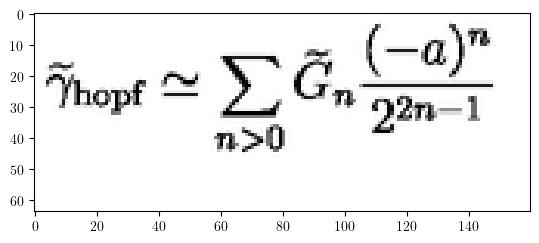

In [3]:
my_text_processor = TextProcesser("../data/latex_vocab_new")
for (img,target_in),target_out in complete_train_ds.take(1):

    print(my_text_processor.Id_tensor_to_string(target_out[0]))
    print(target_out[0])
    print(target_in[0])

    plt.imshow(img[0], cmap='gray')
    plt.show()
    
    break

## Initialize Model und load weights

In [4]:
my_text_processor = TextProcesser("../data/latex_vocab_new")

model = Decompiler(my_text_processor, units=64, dec_units=128, name='decompiler')

model.compile(
    optimizer=keras.optimizers.Adam(clipnorm=1.),
    loss=masked_loss,
    metrics=[masked_loss, masked_acc],
)
model.load_weights('net_saves/save2')




## Test Model with examples from the validation Dataset

1.0 0.0


2025-01-15 12:29:52.190929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-15 12:29:52.331968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-15 12:29:52.343343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Prediction: 
 A \vec { u } _ { \mathrm { i } } = R U \vec { u } _ { \mathrm { i } } = R U \vec { u } _ { \mathrm { i } } = \lambda _ { \mathrm { i } } ( R \vec { u } _ { \mathrm { i } } ) = V ( R \vec { u } _ { \mathrm { i } } ) ,                    
Label: 
  A \vec { u } _ { \mathrm { i } } = R U \vec { u } _ { \mathrm { i } } = \lambda _ { \mathrm { i } } ( R \vec { u } _ { \mathrm { i } } ) = V ( R \vec { u } _ { \mathrm { i } } ) ,                                                                                    


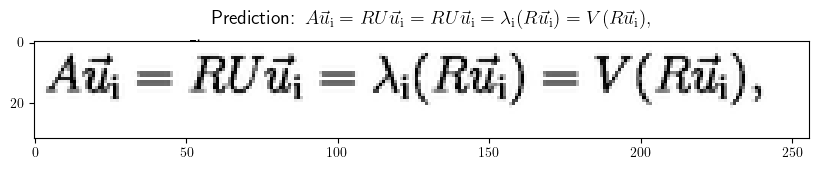

In [5]:
rcParams['text.usetex'] = True

rand1, rand2 = np.random.randint(0, 300), np.random.randint(0, 16) # choose random image and label
ds = complete_validate_ds.skip(rand1)
for (i,j),k in ds.take(1): # type: ignore
    input_image = tf.expand_dims(i[rand2], 0)

    # decompile
    p = model.decompile(input_image)
    label = model.Decoder.label_to_text(j[rand2])
    print(f'Prediction: \n {p}')
    print(f'Label: \n {label}')
    try:
        txte = rf"Prediction: ${p}$ \\ _."
        label = rf"Label: ${label}$ \\ _."
    except:

        print('parsing not possible')
        txte = 'Parsing not possible'
    
    # plot image
    fig, ax = plt.subplots(figsize=(10,5))
    ax.imshow(input_image[0,:,:,:], cmap='gray')
    ax.set_title(txte, fontsize=14)

    plt.show()





**Label**
$$
  P _ { 0 } = \sum _ { \sigma _ { 1 } \sigma _ { 2 } } P _ { 0 } ^ { \sigma _ { 1 } \sigma _ { 2 } } \, .                                                                                                              
                        

$$



**Pred**
$$
 P _ { 0 } = \sum _ { \sigma _ { 1 } \sigma _ { 2 } } P _ { 0 } ^ { \sigma _ { 1 } \sigma _ { 2 } } \, .                                                            

                   


$$

There's a problem with rendering labels that contain `\hspace{ c m }`. The 'cm' should be written without whitespace. 
Also, it appears that the `\operatorname` command is not recognized by the compiler. A post Processer which reads in the String an removes this whitespace could help with that. 

I think annother Problem is that the max tokens are set to low. some formulas are cut of at a certain point

The summuation index is printed right to the summation symbole. Thats not a problem with the model but rather with the matplotlib latex compiler

## Plotting the attention scores
Whats the shape affter the Cnn? 
> shape after Cnn is now safed as self.context_shape

1.0 0.0
(1, 100, 768)
[]


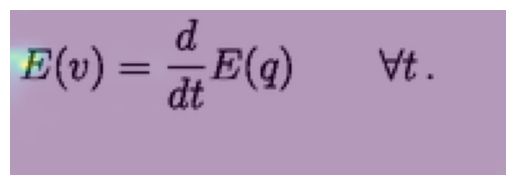

['E']


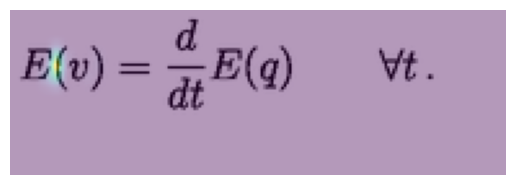

['E', '(']


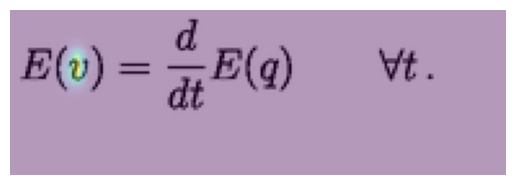

['E', '(', 'v']


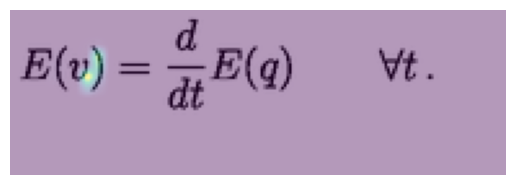

['E', '(', 'v', ')']


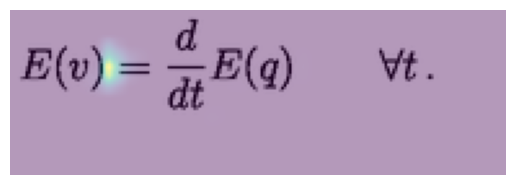

['E', '(', 'v', ')', '=']


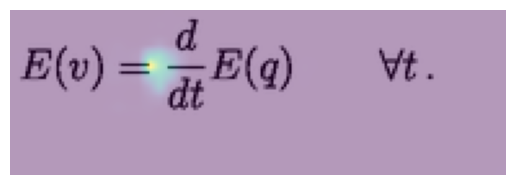

['E', '(', 'v', ')', '=', '\\frac']


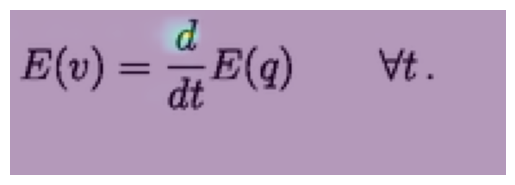

['E', '(', 'v', ')', '=', '\\frac', '{']


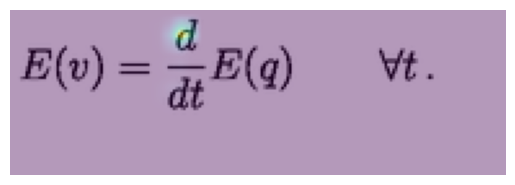

['E', '(', 'v', ')', '=', '\\frac', '{', 'd']


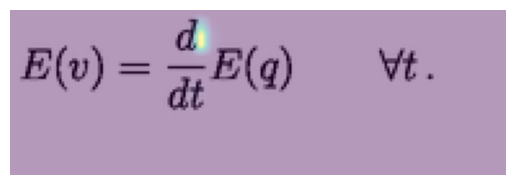

['(', 'v', ')', '=', '\\frac', '{', 'd', '}']


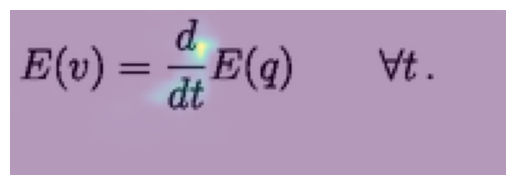

['v', ')', '=', '\\frac', '{', 'd', '}', '{']


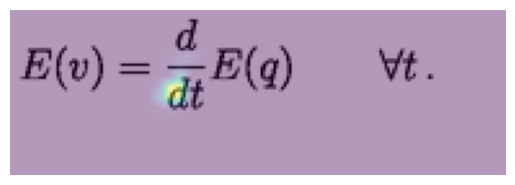

[')', '=', '\\frac', '{', 'd', '}', '{', 'd']


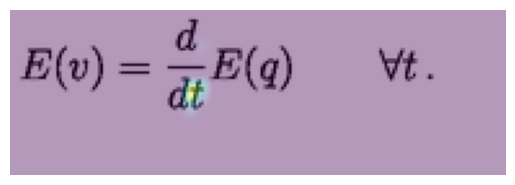

['=', '\\frac', '{', 'd', '}', '{', 'd', 't']


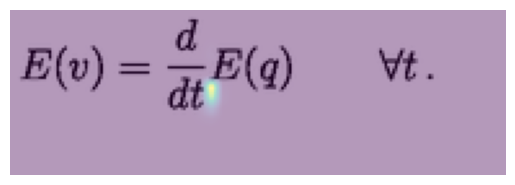

['\\frac', '{', 'd', '}', '{', 'd', 't', '}']


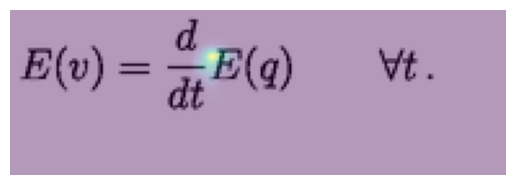

['{', 'd', '}', '{', 'd', 't', '}', 'E']


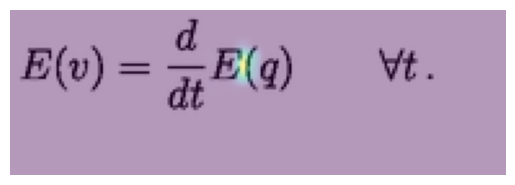

['d', '}', '{', 'd', 't', '}', 'E', '(']


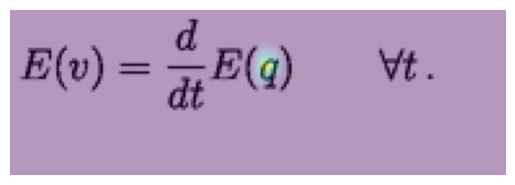

['}', '{', 'd', 't', '}', 'E', '(', 'q']


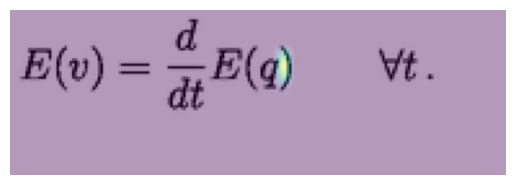

['{', 'd', 't', '}', 'E', '(', 'q', ')']


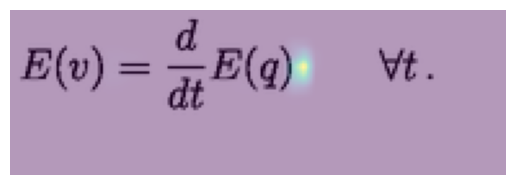

['d', 't', '}', 'E', '(', 'q', ')', '\\qquad']


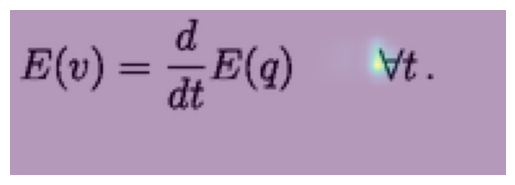

['t', '}', 'E', '(', 'q', ')', '\\qquad', '\\forall']


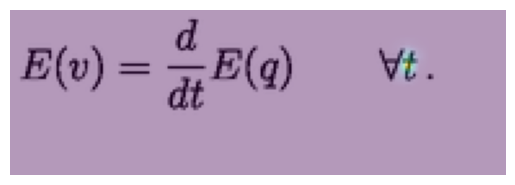

['}', 'E', '(', 'q', ')', '\\qquad', '\\forall', 't']


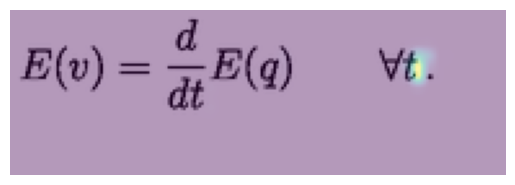

['E', '(', 'q', ')', '\\qquad', '\\forall', 't', '\\,']


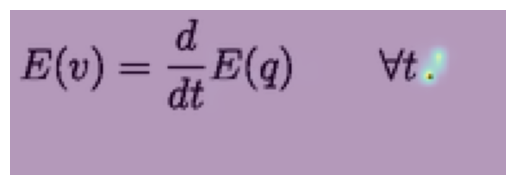

['(', 'q', ')', '\\qquad', '\\forall', 't', '\\,', '.']


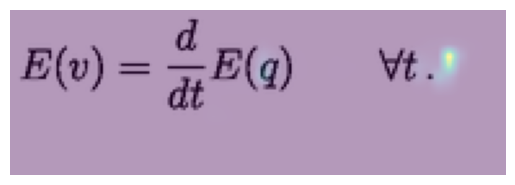

In [23]:
# rand1, rand2 = np.random.randint(0, 300), np.random.randint(0, 16) # choose random image and label
ds = complete_validate_ds.skip(rand1)


for (i,j),k in ds.take(1): # type: ignore
    rcParams['text.usetex'] = False
    input_image = tf.expand_dims(i[rand2], 0)

    model.plot_attention(input_image)

## Try with custom image

### Things to keep in mind while preprocessing custom image
- padd with enough wihtespace at the end to help generate the `[END]` token
- Hight of one Line in formula should be around 40 - 45 to generate best results
- with the here used compiler the letters are sometimes falsely characterized as bold.

1.0 0.0


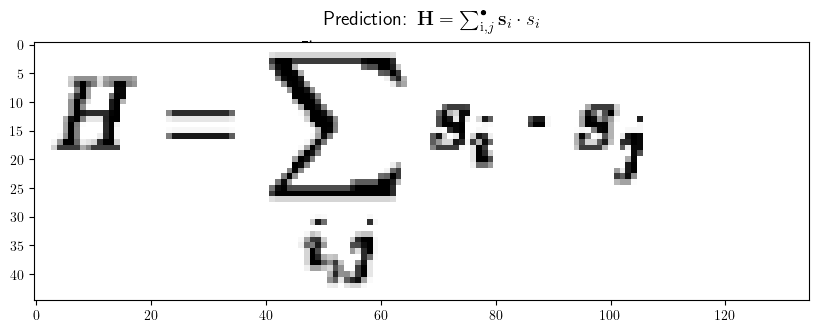

Prediction: 
 { \bf H } = \sum _ { \mathrm { i } , j } ^ { \bullet } { \bf s } _ { i } \cdot s _ { i }                                                                   


In [64]:
IMAGE_PATH = '/home/stud/ge42nog/projects/pix2tex/data/CodeCogsEqn.png'

def predict_image(path=IMAGE_PATH):
    # prepare image

    # TODO: automate preprocessing of image to fit model input

    my_image = plt.imread(path)
    img = np.pad(my_image[:,:,0], ((3,3), (3,30)), constant_values=1)
    input_image = tf.expand_dims(tf.expand_dims(img, axis=0), axis=-1)
    input_image = tf.image.resize(input_image, (45,1300), preserve_aspect_ratio=True)
    # decompile
    p = model.decompile(input_image)
    

    # plot image
    txte = rf"Prediction: ${p}$ \\ _."
    fig, ax = plt.subplots(figsize=(10,5))
    ax.imshow(input_image[0,:,:,:], cmap='gray') # type: ignore
    try:
        ax.set_title(txte, fontsize=14)
        plt.show()
    except:
        ax.set_title(f'Not able to compile predicted formula...')
        plt.show()


    print(f'Prediction: \n {p}')
    

predict_image()